In [65]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import Pdb

In [50]:
class Perceptron(object):
    """
        パーセプトロンの分類器

        パラメータ
        -------------
        eta : float
            学習率
        n_iter : int
            訓練データの訓練回数
        random_state : int
            重みを初期化するための乱数シード

        属性
        --------------
        w_ : 1次元配列
            適合後の重み
        errors_ : リスト
            各エポックでの誤分類（更新）の数
    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    """
        訓練データに適合させる

        パラメータ
        --------------
        X : {配列のような構造}, shape = [n_examples, n_features]
            訓練データ
            n_examplesは訓練データの個数、n_featuresは特徴量の個数
        y : 配列のような構造, shape = [n_examples]
            目的変数
    """
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)

        """
        loc: float or array_like of floats
            Mean (“centre”) of the distribution.

        scale: float or array_like of floats
            Standard deviation (spread or “width”) of the distribution. Must be non-negative.

        size: int or tuple of ints, optional
            Output shape.
        # https://numpy.org/doc/2.0/reference/random/generated/numpy.random.normal.html

        重みをランダムで初期化。０で初期化すると学習率が分類の結果に影響を与えないため正規分布に従った小さな値で初期化する。
        w0にバイアスが入るため+1
        size=1 + X.shape[1]
        """
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X,y): # 各訓練データで重みを更新
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)

            self.errors_.append(errors)

        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)
            

In [22]:
rgen = np.random.RandomState(1)
w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + 4)

In [23]:
s = os.path.join('https://archive.ics.uci.edu', 'ml', 'machine-learning-databases', 'iris', 'iris.data')
df = pd.read_csv(s, header=None, encoding='utf-8')
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


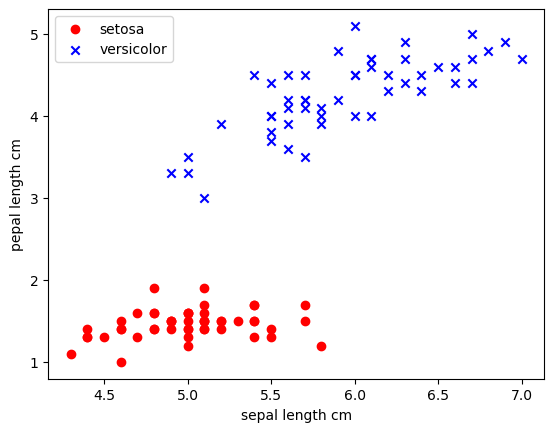

In [46]:
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)
X = df.iloc[0:100, [0,2]].values
plt.scatter(X[:50,0], X[:50,1], color='red', marker='o', label='setosa')
plt.scatter(X[50:100,0], X[50:100,1], color='blue', marker='x', label='versicolor')
plt.xlabel('sepal length cm')
plt.ylabel('pepal length cm')
plt.legend(loc='upper left')
plt.show()

In [52]:
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X,y)

ppn.errors_

[1, 3, 3, 2, 1, 0, 0, 0, 0, 0]

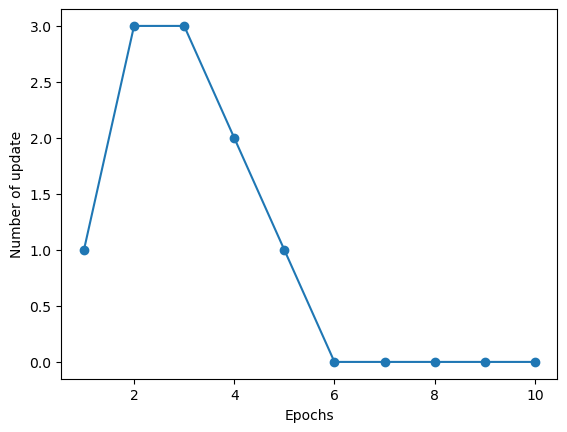

In [53]:
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of update')
plt.show()

In [68]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y , classifier, resolution = 0.02):
    # マーカーとカラーマップの準備
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # 決定領域のプロット
    x1_min, x1_max =  X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max =  X[:, 1].min() - 1, X[:, 1].max() + 1

    # 各特徴量を１次元配列に変換して予測を実行
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=cl
                   )

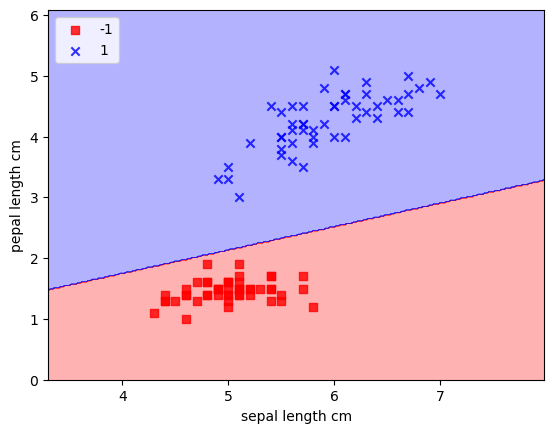

In [69]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length cm')
plt.ylabel('pepal length cm')
plt.legend(loc='upper left')
plt.show()

In [117]:
class AdalineGD(object):
    """
        属性
        --------------
        cost_ : リスト
            各エポックでの誤差平方和のコスト関数
    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)

        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return X

    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)


In [92]:
ada = AdalineGD(eta=0.0004, n_iter=25)
ada.fit(X,y)

ada.cost_

[51.08122709777622,
 45.809820799841205,
 41.66300782162972,
 38.131224922743684,
 35.00284916049393,
 32.182142134302865,
 29.6191513350066,
 27.282657551365084,
 25.1496782636554,
 23.20134352650625,
 21.421229109355174,
 19.79464122828882,
 18.30827348990627,
 16.95001278196557,
 15.708807782483989,
 14.57456644069584,
 13.538069073808419,
 12.590891559521644,
 11.725336149686976,
 10.934368631526599,
 10.21156105229118,
 9.55103943676551,
 8.947436032309422,
 8.39584567778827,
 7.8917859358231635]

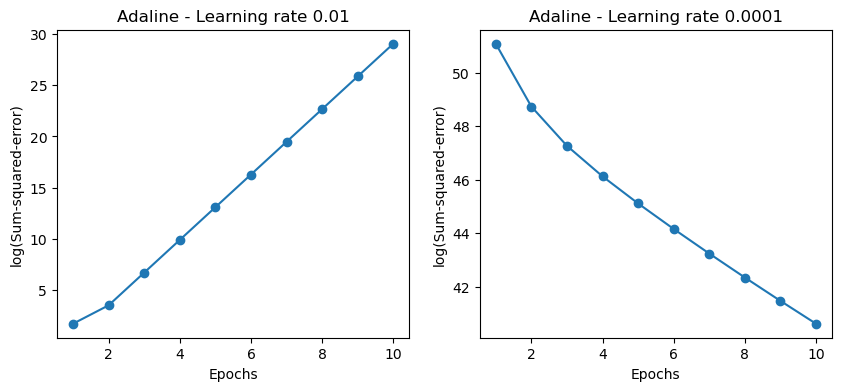

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
adal = AdalineGD(n_iter=10, eta=0.01).fit(X, y)

ax[0].plot(range(1, len(adal.cost_)+1), np.log10(adal.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

adal_2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(adal_2.cost_) + 1), adal_2.cost_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('log(Sum-squared-error)')
ax[1].set_title('Adaline - Learning rate 0.0001')
plt.show()

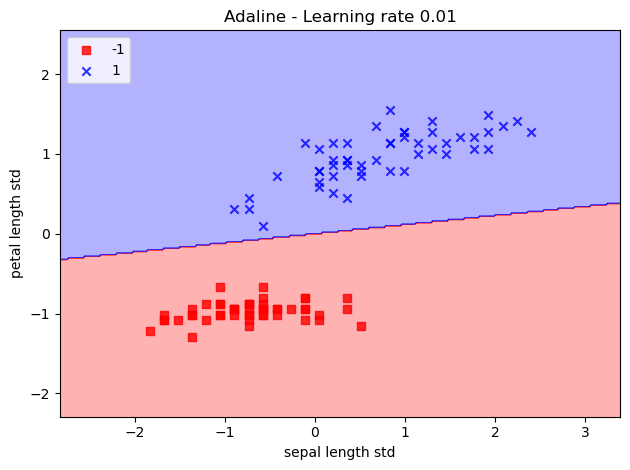

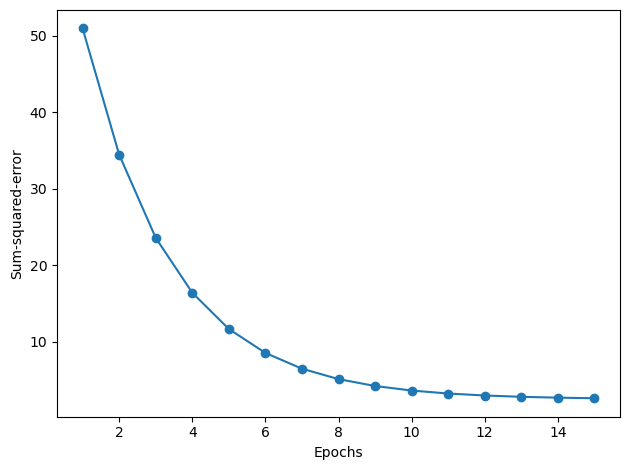

In [123]:
X_std = np.copy(X)

X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

ada_gd = AdalineGD(n_iter=15, eta=0.01).fit(X_std, y)
plot_decision_regions(X_std, y, classifier=ada_gd)

plt.title('Adaline - Learning rate 0.01')
plt.xlabel('sepal length std')
plt.ylabel('petal length std')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_gd.cost_) + 1), ada_gd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()

In [140]:
# 確率的勾配下降法
class AdalineSGD(object):
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)

            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))

            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)

        return self

    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])

        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)

        else:
            self._update_weights(X, y)

        return self

    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ =  self.rgen.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return X

    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)


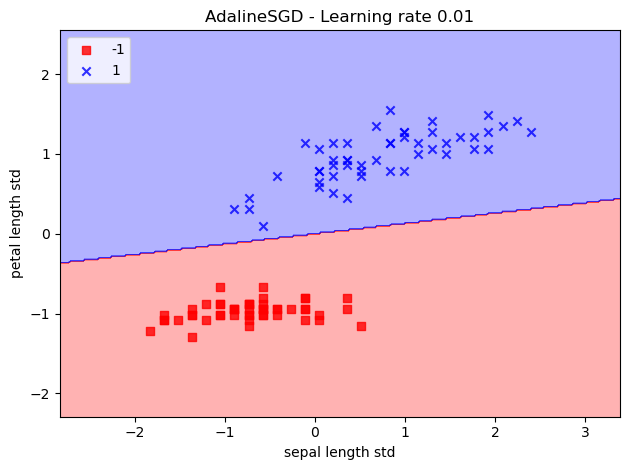

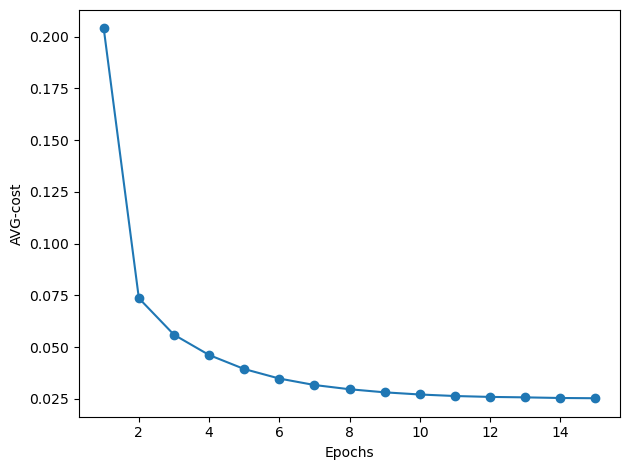

In [141]:
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada_sgd)
plt.title('AdalineSGD - Learning rate 0.01')
plt.xlabel('sepal length std')
plt.ylabel('petal length std')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada_sgd.cost_) + 1), ada_sgd.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('AVG-cost')
plt.tight_layout()
plt.show()